## Import Libraries

In [1]:
from os import path, mkdir

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torch.nn.functional as F

import torchvision
import torchvision.models
from torchvision import transforms

import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

### Check GPU Availability

In [2]:
!nvidia-smi

Sun Aug 18 21:32:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |    877MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [3]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 5

device = torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_NUM)
    device = torch.device("cuda")
print("INFO: Using device -", device)

INFO: Using device - cuda


## Load DataSets

In [4]:
from typing import Callable, Optional
from torchvision.datasets.utils import download_and_extract_archive

torchvision.datasets.utils.tqdm = tqdm


class FoodImageDataset(torchvision.datasets.ImageFolder):
    download_url = "https://daiv-cnu.duckdns.org/contest/ai_competition[2024]_basic/dataset/datasets.zip"

    def __init__(self, root: str, force_download: bool = True, train: bool = True, valid: bool = False, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None):
        self.download(root, force=force_download)

        if train:
            if valid:
                root = path.join(root, "valid")
            else:
                root = path.join(root, "train")
        else:
            root = path.join(root, "test")

        super().__init__(root=root, transform=transform, target_transform=target_transform)

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not path.isfile(path.join(root, "datasets.zip")):
            download_and_extract_archive(cls.download_url, download_root=root, extract_root=root, filename="datasets.zip")
            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

In [5]:
class MixupTransform:
    def __init__(self, dataset, p=0.5, alpha=0.2):
        self.dataset = dataset
        self.p = p
        self.alpha = alpha

    def __call__(self, img):
        if random.random() > self.p:
            return img

        idx = random.randint(0, len(self.dataset) - 1)
        img2, label2 = self.dataset[idx]

        # img2가 Tensor일 경우 PIL 이미지로 변환
        if isinstance(img2, torch.Tensor):
            img2 = transforms.ToPILImage()(img2)

        # 이미지 크기 확인
        if img.size != img2.size:
            img2 = img2.resize(img.size, Image.BILINEAR)

        # Mixup 적용
        try:
            lam = np.random.beta(self.alpha, self.alpha)
            img = Image.blend(img, img2, lam)
        except Exception as e:
            print(f"Error in blending images: {e}")
            pass  # 문제가 있으면 원본 이미지를 반환

        return img

In [6]:
IMG_SIZE = (512, 512)
IMG_NORM = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
CLASS_LABELS = 11
DATA_ROOT = path.join(".", "data")

In [7]:
# 기본 변환 (리사이징 및 정규화만)
basic_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(**IMG_NORM)
])

augment_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # 모든 이미지를 동일한 크기로 조정
    transforms.RandomResizedCrop(IMG_SIZE[0], scale=(0.8, 1.0)),  # 항상 적용되도록 설정
    transforms.RandomHorizontalFlip(p=1.0),  # 항상 좌우 반전 적용
    transforms.RandomVerticalFlip(p=1.0),  # 항상 상하 반전 적용
    transforms.RandomRotation(15),  # 항상 회전 적용
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 항상 색상 변형 적용
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 항상 이동 변형 적용
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # 항상 가우시안 블러 적용
    transforms.RandomCrop(IMG_SIZE[0], padding=4),  # 항상 크롭 적용
    transforms.ToTensor(),
    transforms.Normalize(**IMG_NORM)
])

In [8]:
original_train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=basic_transform)
augmented_train_datasets = [FoodImageDataset(root=DATA_ROOT, force_download=False, train=True,transform=augment_transform) for _ in range(2)]

train_dataset = ConcatDataset([original_train_dataset] + augmented_train_datasets)
valid_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, valid=True, transform=basic_transform)
test_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=False, transform=basic_transform)
print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(29598), Valid(3430), Test(3347)


## Data Augmentation if needed

## DataLoader

In [23]:
# Set Batch Size
BATCH_SIZE = 24

In [10]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)

INFO: Number of CPU cores - 48


## Define Model

### 0. BaselineModel

In [119]:
class ImageClassifier(nn.Module):
    def __init__(self, input_channel: int, output_channel: int, img_size: int, num_classes: int):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel//4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=output_channel//4, out_channels=output_channel//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=output_channel//2, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Assuming you want to connect to a fully connected layer after flattening
        # Calculate the size of the flattened features after 3 pooling layers
        self.fc_size = output_channel * (img_size // 2**3) * (img_size // 2**3)
        self.fc = nn.Linear(self.fc_size, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.fc(out)
        return out

### 1. ResNetWithAttention

In [11]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, H, W = x.size()
        query = self.query(x).view(batch_size, -1, H * W).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, H * W)
        energy = torch.bmm(query, key)
        attention = torch.softmax(energy, dim=-1)
        value = self.value(x).view(batch_size, -1, H * W)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, H, W)
        return self.gamma * out + x

In [15]:
class ResNetWithAttention(nn.Module):
    def __init__(self, num_classes=11):
        super().__init__()
        
        # ResNet50을 기반 모델로 사용
        self.resnet = torchvision.models.resnet50(weights=None)
        
        # 입력 이미지 크기에 맞게 첫 번째 컨볼루션 레이어 조정
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # ResNet의 마지막 fully connected 레이어 제거
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # Self-Attention 레이어 추가
        self.attention = SelfAttention(2048)
        
        # Global Average Pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected 레이어
        self.fc1 = nn.Linear(2048, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = self.attention(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### 2. ResNet

In [122]:
class ResNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        
        self.resnet = torchvision.models.resnet18(weights=None)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

### 3. EfficientNet

In [123]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.efficientnet = torchvision.models.efficientnet_b0(weights=None)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.efficientnet(x)
        return x

In [124]:
# EfficientNet에 Self-Attention Layer 추가
class EfficientNetWithAttention(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.efficientnet = torchvision.models.efficientnet_b0(weights=None)
        
        # EfficientNet의 마지막 Conv 네트워크를 가져옴
        self.features = self.efficientnet.features
        
        # Self-Attention Layer 추가
        self.attention = SelfAttention(in_dim=1280)  # EfficientNet-B0의 마지막 출력 채널 수는 1280입니다.
        
        # 원래의 EfficientNet의 분류기 부분
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # EfficientNet의 특징 추출 부분
        x = self.features(x)
        
        # Self-Attention 적용
        x = self.attention(x)
        
        # Global Average Pooling
        x = torch.mean(x, dim=[2, 3])  # 평균 풀링을 사용하여 특징 맵을 평탄화합니다.
        
        # 분류기 부분
        x = self.classifier(x)
        return x

### Initialize Model

In [24]:
# Initialize Model
model = ResNetWithAttention(num_classes=CLASS_LABELS)
model.to(device)

ResNetWithAttention(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

LEARNING_RATE = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

## Training Loop

In [26]:
from IPython.display import display
import ipywidgets as widgets

# Interactive Loss Plot Update
def create_plot():
    losses = []

    # Enable Interactive Mode
    plt.ion()

    # Loss Plot Setting
    fig, ax = plt.subplots(figsize=(6, 2))
    line, = ax.plot(losses)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Cross Entropy Loss")

    # Display Plot
    plot = widgets.Output()
    display(plot)

    def update_plot(new_loss):
        losses.append(new_loss.item())
        line.set_ydata(losses)
        line.set_xdata(range(len(losses)))
        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [27]:
# Set Epoch Count
num_epochs = 200

Running Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1850 [00:00<?, ?it/s]

Validation:   0%|          | 0/215 [00:00<?, ?it/s]

Output()

Epoch [ 1/200], Step [1850/1850], Loss: 2.357158, Valid Acc: 15.364426%, Valid Loss: 2.281528

Epoch [ 2/200], Step [1850/1850], Loss: 2.036085, Valid Acc: 24.956268%, Valid Loss: 2.072723

Epoch [ 3/200], Step [1850/1850], Loss: 1.934624, Valid Acc: 30.466473%, Valid Loss: 1.954125

Epoch [ 4/200], Step [1850/1850], Loss: 2.033597, Valid Acc: 33.206993%, Valid Loss: 1.865003

Epoch [ 5/200], Step [1850/1850], Loss: 1.854265, Valid Acc: 38.542283%, Valid Loss: 1.737148


Epoch [ 6/200], Step [1850/1850], Loss: 2.151182, Valid Acc: 37.230334%, Valid Loss: 1.742677

Epoch [ 7/200], Step [1850/1850], Loss: 1.415590, Valid Acc: 41.574359%, Valid Loss: 1.672096

Epoch [ 8/200], Step [1850/1850], Loss: 1.517873, Valid Acc: 43.352774%, Valid Loss: 1.634238

Epoch [ 9/200], Step [1850/1850], Loss: 1.706832, Valid Acc: 46.326542%, Valid Loss: 1.553473

Epoch [10/200], Step [1850/1850], Loss: 1.448043, Valid Acc: 50.058299%, Valid Loss: 1.444973


Epoch [11/200], Step [1850/1850], Loss: 1.405174, Valid Acc: 47.813421%, Valid Loss: 1.482708

Epoch [12/200], Step [1850/1850], Loss: 1.873597, Valid Acc: 51.282793%, Valid Loss: 1.445557

Epoch [13/200], Step [1850/1850], Loss: 1.449503, Valid Acc: 53.469384%, Valid Loss: 1.342734

Epoch [14/200], Step [1850/1850], Loss: 1.823360, Valid Acc: 52.157444%, Valid Loss: 1.371707

Epoch [15/200], Step [1850/1850], Loss: 1.649004, Valid Acc: 55.889207%, Valid Loss: 1.285552


Epoch [16/200], Step [1850/1850], Loss: 1.216679, Valid Acc: 56.967926%, Valid Loss: 1.263345

Epoch [17/200], Step [1850/1850], Loss: 1.061256, Valid Acc: 55.743450%, Valid Loss: 1.291952

Epoch [18/200], Step [1850/1850], Loss: 1.879122, Valid Acc: 58.833814%, Valid Loss: 1.216983

Epoch [19/200], Step [1850/1850], Loss: 1.400165, Valid Acc: 61.428547%, Valid Loss: 1.160371

Epoch [20/200], Step [1850/1850], Loss: 1.350857, Valid Acc: 59.941697%, Valid Loss: 1.180066


Epoch [21/200], Step [1850/1850], Loss: 1.164138, Valid Acc: 63.236105%, Valid Loss: 1.083523

Epoch [22/200], Step [1850/1850], Loss: 1.176156, Valid Acc: 60.874623%, Valid Loss: 1.136547

Epoch [23/200], Step [1850/1850], Loss: 1.241180, Valid Acc: 60.291511%, Valid Loss: 1.176483

Epoch [24/200], Step [1850/1850], Loss: 1.600304, Valid Acc: 66.034961%, Valid Loss: 1.016526

Epoch [25/200], Step [1850/1850], Loss: 1.939815, Valid Acc: 65.830845%, Valid Loss: 1.009942


Epoch [26/200], Step [1850/1850], Loss: 1.028360, Valid Acc: 65.860039%, Valid Loss: 1.001602

Epoch [27/200], Step [1850/1850], Loss: 1.147217, Valid Acc: 68.892103%, Valid Loss: 0.932357

Epoch [28/200], Step [1850/1850], Loss: 1.076990, Valid Acc: 69.650131%, Valid Loss: 0.938910

Epoch [29/200], Step [1850/1850], Loss: 1.085217, Valid Acc: 66.064131%, Valid Loss: 1.008804

Epoch [30/200], Step [1850/1850], Loss: 1.093701, Valid Acc: 68.979573%, Valid Loss: 0.940080


Epoch [31/200], Step [1850/1850], Loss: 0.945927, Valid Acc: 69.300270%, Valid Loss: 0.934531

Epoch [32/200], Step [1850/1850], Loss: 0.838748, Valid Acc: 70.641387%, Valid Loss: 0.862845

Epoch [33/200], Step [1850/1850], Loss: 0.411334, Valid Acc: 68.396479%, Valid Loss: 0.960847

Epoch [34/200], Step [1850/1850], Loss: 0.901768, Valid Acc: 70.058304%, Valid Loss: 0.923323

Epoch [35/200], Step [1850/1850], Loss: 0.511752, Valid Acc: 70.641345%, Valid Loss: 0.916691


Epoch [36/200], Step [1850/1850], Loss: 0.979870, Valid Acc: 70.145750%, Valid Loss: 0.879050

Epoch [37/200], Step [1850/1850], Loss: 0.640971, Valid Acc: 72.157443%, Valid Loss: 0.847668

Epoch [38/200], Step [1850/1850], Loss: 1.074051, Valid Acc: 71.690929%, Valid Loss: 0.840751

Epoch [39/200], Step [1850/1850], Loss: 0.352109, Valid Acc: 72.507244%, Valid Loss: 0.843061

Epoch [40/200], Step [1850/1850], Loss: 0.668644, Valid Acc: 73.381859%, Valid Loss: 0.838859


Epoch [41/200], Step [1850/1850], Loss: 1.025657, Valid Acc: 72.973746%, Valid Loss: 0.840378

Epoch [42/200], Step [1850/1850], Loss: 0.751397, Valid Acc: 73.381883%, Valid Loss: 0.851608

Epoch [43/200], Step [1850/1850], Loss: 0.413759, Valid Acc: 73.061216%, Valid Loss: 0.870357

Epoch [44/200], Step [1850/1850], Loss: 0.679102, Valid Acc: 72.886282%, Valid Loss: 0.850676

Epoch [45/200], Step [1850/1850], Loss: 0.560490, Valid Acc: 74.518943%, Valid Loss: 0.791637


Epoch [46/200], Step [1850/1850], Loss: 0.602753, Valid Acc: 73.294437%, Valid Loss: 0.836100

Epoch [47/200], Step [1850/1850], Loss: 1.082643, Valid Acc: 72.915459%, Valid Loss: 0.860503

Epoch [48/200], Step [1850/1850], Loss: 0.728834, Valid Acc: 72.507250%, Valid Loss: 0.847649

Epoch [49/200], Step [1850/1850], Loss: 0.787000, Valid Acc: 72.536421%, Valid Loss: 0.899836

Epoch [50/200], Step [1850/1850], Loss: 0.235461, Valid Acc: 73.702592%, Valid Loss: 0.840187


Epoch [51/200], Step [1850/1850], Loss: 0.494261, Valid Acc: 73.411047%, Valid Loss: 0.856819

Epoch [52/200], Step [1850/1850], Loss: 0.666091, Valid Acc: 74.781305%, Valid Loss: 0.820882

Epoch [53/200], Step [1850/1850], Loss: 0.985812, Valid Acc: 74.169064%, Valid Loss: 0.826455

Epoch [54/200], Step [1850/1850], Loss: 0.515171, Valid Acc: 75.801742%, Valid Loss: 0.806209

Epoch [55/200], Step [1850/1850], Loss: 0.494597, Valid Acc: 75.685108%, Valid Loss: 0.783310


Epoch [56/200], Step [1850/1850], Loss: 1.261415, Valid Acc: 74.927104%, Valid Loss: 0.839954

Epoch [57/200], Step [1850/1850], Loss: 0.371524, Valid Acc: 74.052465%, Valid Loss: 0.882212

Epoch [58/200], Step [1850/1850], Loss: 0.407998, Valid Acc: 74.897933%, Valid Loss: 0.890227

Epoch [59/200], Step [1850/1850], Loss: 0.250979, Valid Acc: 75.685120%, Valid Loss: 0.859486

KeyboardInterrupt: 

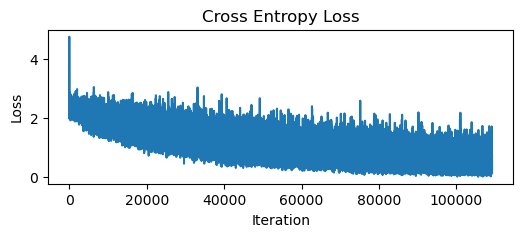

In [28]:
train_length, valid_length = map(len, (train_loader, valid_loader))

epochs = tqdm(range(num_epochs), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        # Training
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            update(loss)
            train_progress.update(1)

        val_acc, val_loss = 0, 0

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum() / len(valid_dataset)
                valid_progress.update(1)

        print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{train_length}/{train_length}], Loss: {loss.item():.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == num_epochs else "")

## Weights Initialize

In [30]:
if not path.isdir(path.join(".", "models")):
    import os
    os.mkdir(path.join(".", "models"))

model_id = "resnet50_with_attention"
model_info = f"{model_id}__acc__{val_acc:.6f}"

save_path = path.join(".", "models", f"{model_info}.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ./models/resnet50_with_attention__acc__0.756851.pt


# Model Evaluation

In [31]:
# Load Model
model = ResNetWithAttention(num_classes=CLASS_LABELS)

import_model = False
if import_model:
    model_info = "resnet50_with_attention__acc__0.756851.pt"
    
model.load_state_dict(torch.load(path.join(".", "models", f"{model_info}.pt")))
model.to(device)

ResNetWithAttention(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [32]:
results = dict(id=[], label=[])
test_length = len(test_dataset)

# train_dataset에서 'classes' 속성을 얻기 위해 첫 번째 데이터셋 참조
train_classes = train_dataset.datasets[0].classes

model.to(device)
model.eval()
with torch.no_grad():
    for inputs, ids in tqdm(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # test_dataset에서 'classes' 속성을 얻음
        test_classes = test_dataset.classes
        
        results['id'] += [test_classes[i] for i in ids]
        results['label'] += [train_classes[i] for i in preds.cpu().detach().numpy().tolist()]

  0%|          | 0/210 [00:00<?, ?it/s]

In [33]:
# Save Results
results_df = pd.DataFrame(results)

submission_dir = "submissions"
if not path.isdir(submission_dir):
    mkdir(submission_dir)

submit_file_path = path.join(submission_dir, f"{model_info}.csv")
results_df.to_csv(submit_file_path, index=False)
print("File saved to", submit_file_path)

results_df.head()

File saved to submissions/resnet50_with_attention__acc__0.756851.csv


,id,label
0,TEST_0000,Meat
1,TEST_0001,Dairy product
2,TEST_0002,Egg
3,TEST_0003,Meat
4,TEST_0004,Fried food
